In [9]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import numpy as np
from siphon.catalog import get_latest_access_url
from siphon.ncss import NCSS
import xarray as xr
import xarray.ufuncs as xu
import time

class HRRRCast():
    def __init__(self, lat, lon):
        self.var = [
                    'u-component_of_wind_height_above_ground',
                    'v-component_of_wind_height_above_ground',
                    'Temperature_height_above_ground',
                    'Pressure_surface',
                    'Temperature_isobaric',
                    'Pressure_reduced_to_MSL_msl',
                    'Geopotential_height_surface',
                    'Total_cloud_cover_entire_atmosphere',
                    'Temperature_height_above_ground',
                    'Total_precipitation_surface_1_Hour_Accumulation',
                    'Convective_available_potential_energy_surface',
                    'Surface_lifted_index_isobaric_layer',
                    'Wind_speed_gust_surface',
                    'Hourly_Maximum_of_Upward_Vertical_Velocity_in_the_lowest_400hPa_pressure_difference_layer_1_Hour_Maximum',
                    ]
        self.north =lat+1
        self.south =lat-1
        self.east=lon+1
        self.west=lon-1
        self.latest_access_url = None
        self.isobar = 0
        self.height = 0
        self.nc = None
    
    def update(self):
        latest_access_url = get_latest_access_url("http://thredds.ucar.edu/thredds/catalog/grib/NCEP/HRRR/CONUS_2p5km/catalog.xml", "NetcdfSubset")
        if self.latest_access_url == latest_access_url:
            return
        self.latest_access_url = latest_access_url
        ncss = NCSS(latest_access_url)
        query = ncss.query()
        query.accept('netcdf4')
        query.all_times()
        query.lonlat_box(north=self.north, south=self.south, east=self.east, west=self.west)
        query.variables(frozenset(self.var))
        
#         self.ncobject = ncss.get_data(query)
        open('temp.nc4', 'wb').write(ncss.get_data_raw(query))
        self.nc = xr.load_dataset('temp.nc4')
        xr.set_options(keep_attrs=True)
        
        self.nc['Inverse_Surface_lifted_index'] = -self.nc['Surface_lifted_index_isobaric_layer']
        self.nc['Thermal_Instability_isobaric'] = (10000*(self.nc['Temperature_height_above_ground'][:,:,:].where(self.nc['Pressure_surface']>self.nc['isobaric'][self.isobar])-self.nc['Temperature_isobaric'][:,self.isobar,:,:])/(self.nc['Pressure_surface']-self.nc['isobaric'][self.isobar]))-9
        self.nc['Wind_energy_surface'] = xu.square(self.nc['u-component_of_wind_height_above_ground'][:,self.height])+xu.square(self.nc['u-component_of_wind_height_above_ground'][:,self.height])
        self.nc['Wind_speed_surface'] = xu.sqrt(self.nc['Wind_energy_surface'])
        self.var = list(hr.nc.keys())
        self.var.sort()
        
    def forecast(self, var_name = None, var_index = None, barbs = True, streamlines = False, grid_size = 1, hour = '00'):
        nc = self.nc
        var = self.var
        if (var_name is None) and (var_index is not None):
            var_name = var[var_index]
        ncvar = nc[var_name]
        ncwindu = nc['u-component_of_wind_height_above_ground']
        ncwindv = nc['v-component_of_wind_height_above_ground']
        ncvartime = ncvar.dims[0]
        ncwindtime = ncwindu.dims[0]
        ncname = ncvar.name
        nccmap = 'coolwarm'
        ncvcenter = 0
        ncvmin = None
        ncvmax = None
        
        if ncname == 'Thermal_Instability_isobaric':
            ncvmin = -5
            ncvmax = 5
        if ncname == 'Inverse_Surface_lifted_index':
            ncvmin = -5
            ncvmax = 5
        if ncname == 'Wind_speed_gust_surface':
            ncvmin = 0
            ncvcenter = 7.5
            ncvmax = 20
        if ncname == 'Hourly_Maximum_of_Upward_Vertical_Velocity_in_the_lowest_400hPa_pressure_difference_layer_1_Hour_Maximum':
            ncvmin = 0
            ncvcenter = 2
            ncvmax = 5
        if ncname == 'Total_cloud_cover_entire_atmosphere':
            ncvmin = 0
            ncvcenter = 50
            ncvmax = 100
        if ncname == 'Convective_available_potential_energy_surface':
            ncvmax = 500
            
        # some variables have different times arrays
        
        if len(str(hour)) == 1:
            hour = '0'+str(hour)
        
        times_found = 0
        
        ncvartime_index = 0
        for time in nc[ncvartime].data:
            if 'T'+str(hour) in np.datetime_as_string(time):
                times_found += 1
                break
            ncvartime_index += 1

        ncwindtime_index = 0
        for time in nc[ncwindtime].data:
            if 'T'+str(hour) in np.datetime_as_string(time):
                times_found += 1
                break
            ncwindtime_index += 1
        
        if times_found != 2:
            print('Requested time not in dataset')
            return
        
        #km to meters conversion
        x = ncvar.x.data*1000.
        y = ncvar.y.data*1000.
                 
        grid = nc[ncvar.grid_mapping]
        crs = ccrs.LambertConformal(
                                    central_longitude=grid.longitude_of_central_meridian, 
                                    central_latitude=grid.latitude_of_projection_origin, 
                                    standard_parallels=(grid.latitude_of_projection_origin,grid.standard_parallel), 
                                    globe=ccrs.Globe(ellipse='sphere', semimajor_axis=grid.earth_radius)
                                    )
                 
        fig = plt.figure(figsize=(10,10), dpi=200)
        ax = plt.axes(projection=ccrs.PlateCarree())
        
        plt.xlim([self.west,self.east])
        plt.ylim([self.south, self.north])
        
        mesh = ax.pcolorfast(x,y,ncvar[ncvartime_index,::].data.squeeze(), transform=crs, cmap=nccmap, norm = mcolors.TwoSlopeNorm(ncvcenter, vmin=ncvmin, vmax=ncvmax))

        if barbs: ax.barbs(x,y,ncwindu[ncwindtime_index,self.height,::].data.squeeze(),ncwindv[ncwindtime_index,self.height,::].data.squeeze(), transform=crs, length=3, linewidth=0.2)
        if streamlines: ax.streamplot(x,y,ncwindu[ncwindtime_index,self.height,::].data.squeeze(),ncwindv[ncwindtime_index,self.height,::].data.squeeze(), transform=crs, density = 5, color='grey', arrowsize=0.5, linewidth= 0.5)
            
        ax.scatter(-105.300, 40.056, c='black', s=8)
        ax.text(-105.300, 40.056, ' Wonderland', size=8)
        ax.scatter(-105.245, 39.737, c='black', s=8)
        ax.text(-105.245, 39.737, ' Lookout', size=8)
        # ax.scatter(-105.282, 40.133, c='black', s=8)
        # ax.text(-105.282, 40.13, ' Altona', size=8)
        # ax.scatter(-105.271, 40.224, c='black', s=8)
        # ax.text(-105.271, 40.224, ' Lyons', size=8)
        # ax.scatter(-105.419, 40.026, c='black', s=8)
        # ax.text(-105.419, 40.026, ' Sugarloaf', size=8)
        
        gl = ax.gridlines(draw_labels=True, color = 'black', linewidth=0.5)
        gl.xlocator = mticker.FixedLocator(np.arange(self.west,self.east+grid_size,grid_size))
        gl.ylocator = mticker.FixedLocator(np.arange(self.south,self.north+grid_size,grid_size))
        gl.top_labels = False
        gl.right_labels = False
        
        plt.colorbar(mesh, shrink=0.8)
        plt.title(str(nc[ncvartime].data[ncvartime_index])[:-16] + ' ' + ncname[:42]);
        plt.show()

In [10]:
hr = HRRRCast(40,-105)

In [11]:
hr.update()

In [13]:
hr.nc


<xarray.Dataset>
Dimensions:                                                                                                   (height_above_ground1: 1, height_above_ground3: 2, isobaric: 5, isobaric_layer: 1, pressure_difference_layer3: 1, time: 19, time1: 18, x: 77, y: 96)
Coordinates:
  * time                                                                                                      (time) datetime64[ns] ...
  * y                                                                                                         (y) float32 ...
  * x                                                                                                         (x) float32 ...
  * height_above_ground1                                                                                      (height_above_ground1) float32 ...
  * height_above_ground3                                                                                      (height_above_ground3) float32 ...
  * time1                                                                                                     (time1) datetime64[ns] ...
  * pressure_difference_layer3                                                                                (pressure_difference_layer3) float32 ...
  * isobaric                                                                                                  (isobaric) float32 ...
  * isobaric_layer                                                                                            (isobaric_layer) float32 ...
Data variables: (12/18)
    Convective_available_potential_energy_surface                                                             (time, y, x) float32 ...
    LambertConformal_Projection                                                                               int32 ...
    Temperature_height_above_ground                                                                           (time, height_above_ground1, y, x) float32 ...
    u-component_of_wind_height_above_ground                                                                   (time, height_above_ground3, y, x) float32 ...
    Total_cloud_cover_entire_atmosphere                                                                       (time, y, x) float32 ...
    Wind_speed_gust_surface                                                                                   (time, y, x) float32 ...
    ...                                                                                                        ...
    Surface_lifted_index_isobaric_layer                                                                       (time, isobaric_layer, y, x) float32 ...
    v-component_of_wind_height_above_ground                                                                   (time, height_above_ground3, y, x) float32 ...
    Inverse_Surface_lifted_index                                                                              (time, isobaric_layer, y, x) float32 ...
    Thermal_Instability_isobaric                                                                              (time, height_above_ground1, y, x) float32 ...
    Wind_energy_surface                                                                                       (time, y, x) float32 ...
    Wind_speed_surface                                                                                        (time, y, x) float32 ...
Attributes: (12/13)
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    Conventions:                                                             ...
    ...                                                                                ...
    featureT

In [14]:
hr.var



['Convective_available_potential_energy_surface',
 'Geopotential_height_surface',
 'Hourly_Maximum_of_Upward_Vertical_Velocity_in_the_lowest_400hPa_pressure_difference_layer_1_Hour_Maximum',
 'Inverse_Surface_lifted_index',
 'LambertConformal_Projection',
 'Pressure_reduced_to_MSL_msl',
 'Pressure_surface',
 'Surface_lifted_index_isobaric_layer',
 'Temperature_height_above_ground',
 'Temperature_isobaric',
 'Thermal_Instability_isobaric',
 'Total_cloud_cover_entire_atmosphere',
 'Total_precipitation_surface_1_Hour_Accumulation',
 'Wind_energy_surface',
 'Wind_speed_gust_surface',
 'Wind_speed_surface',
 'u-component_of_wind_height_above_ground',
 'v-component_of_wind_height_above_ground']

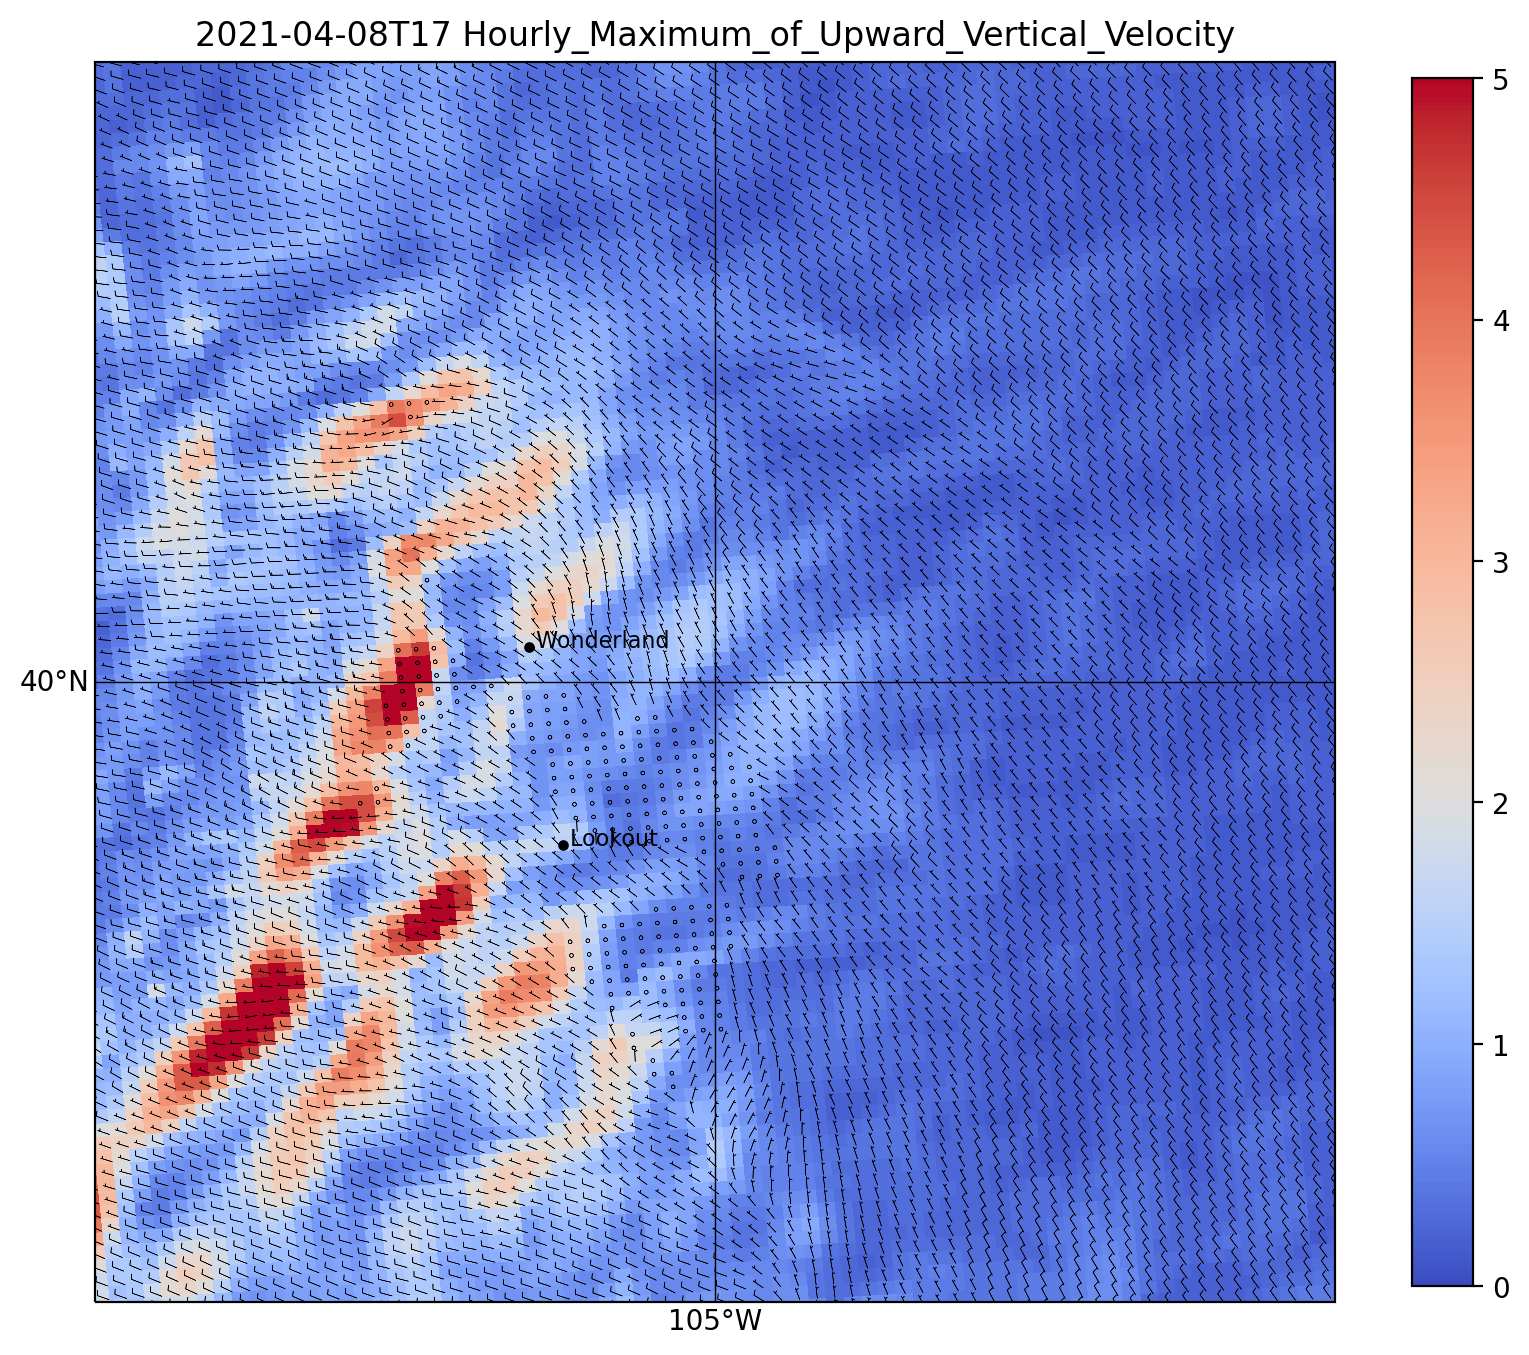

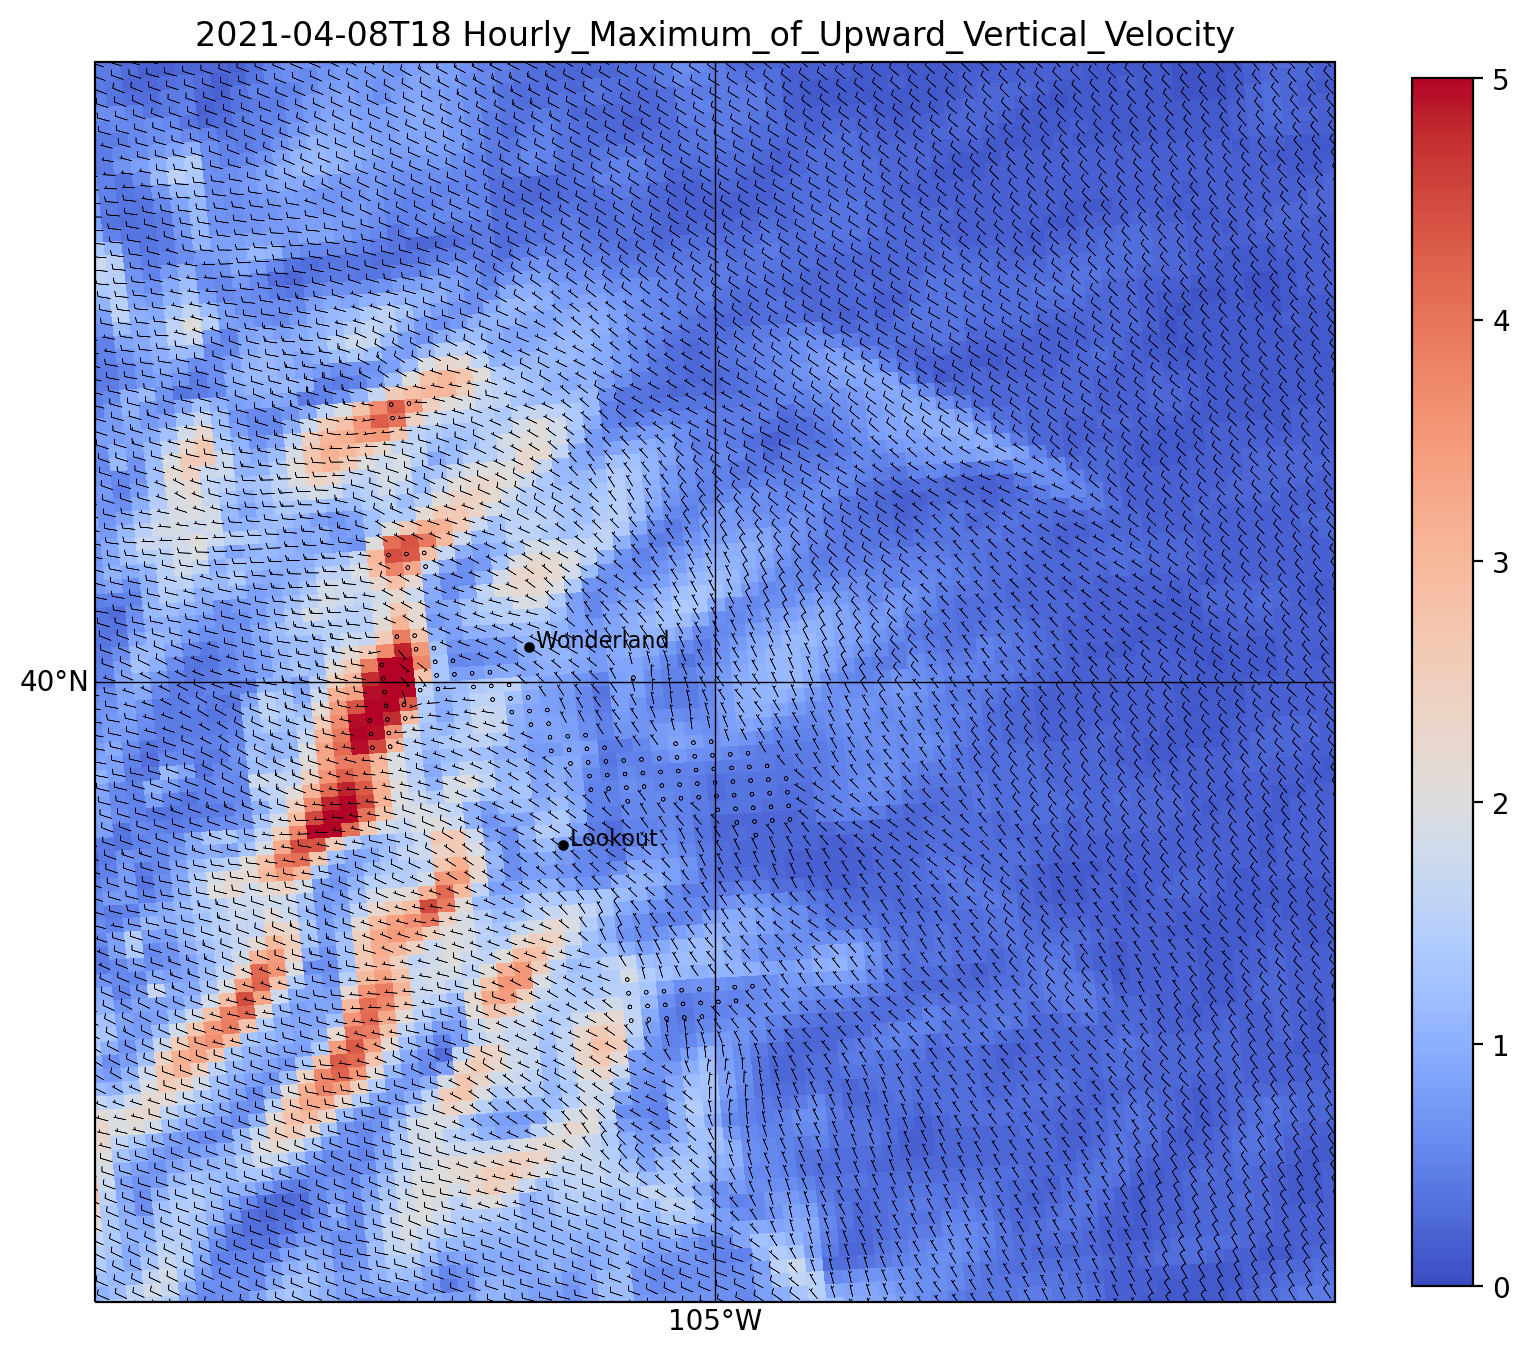

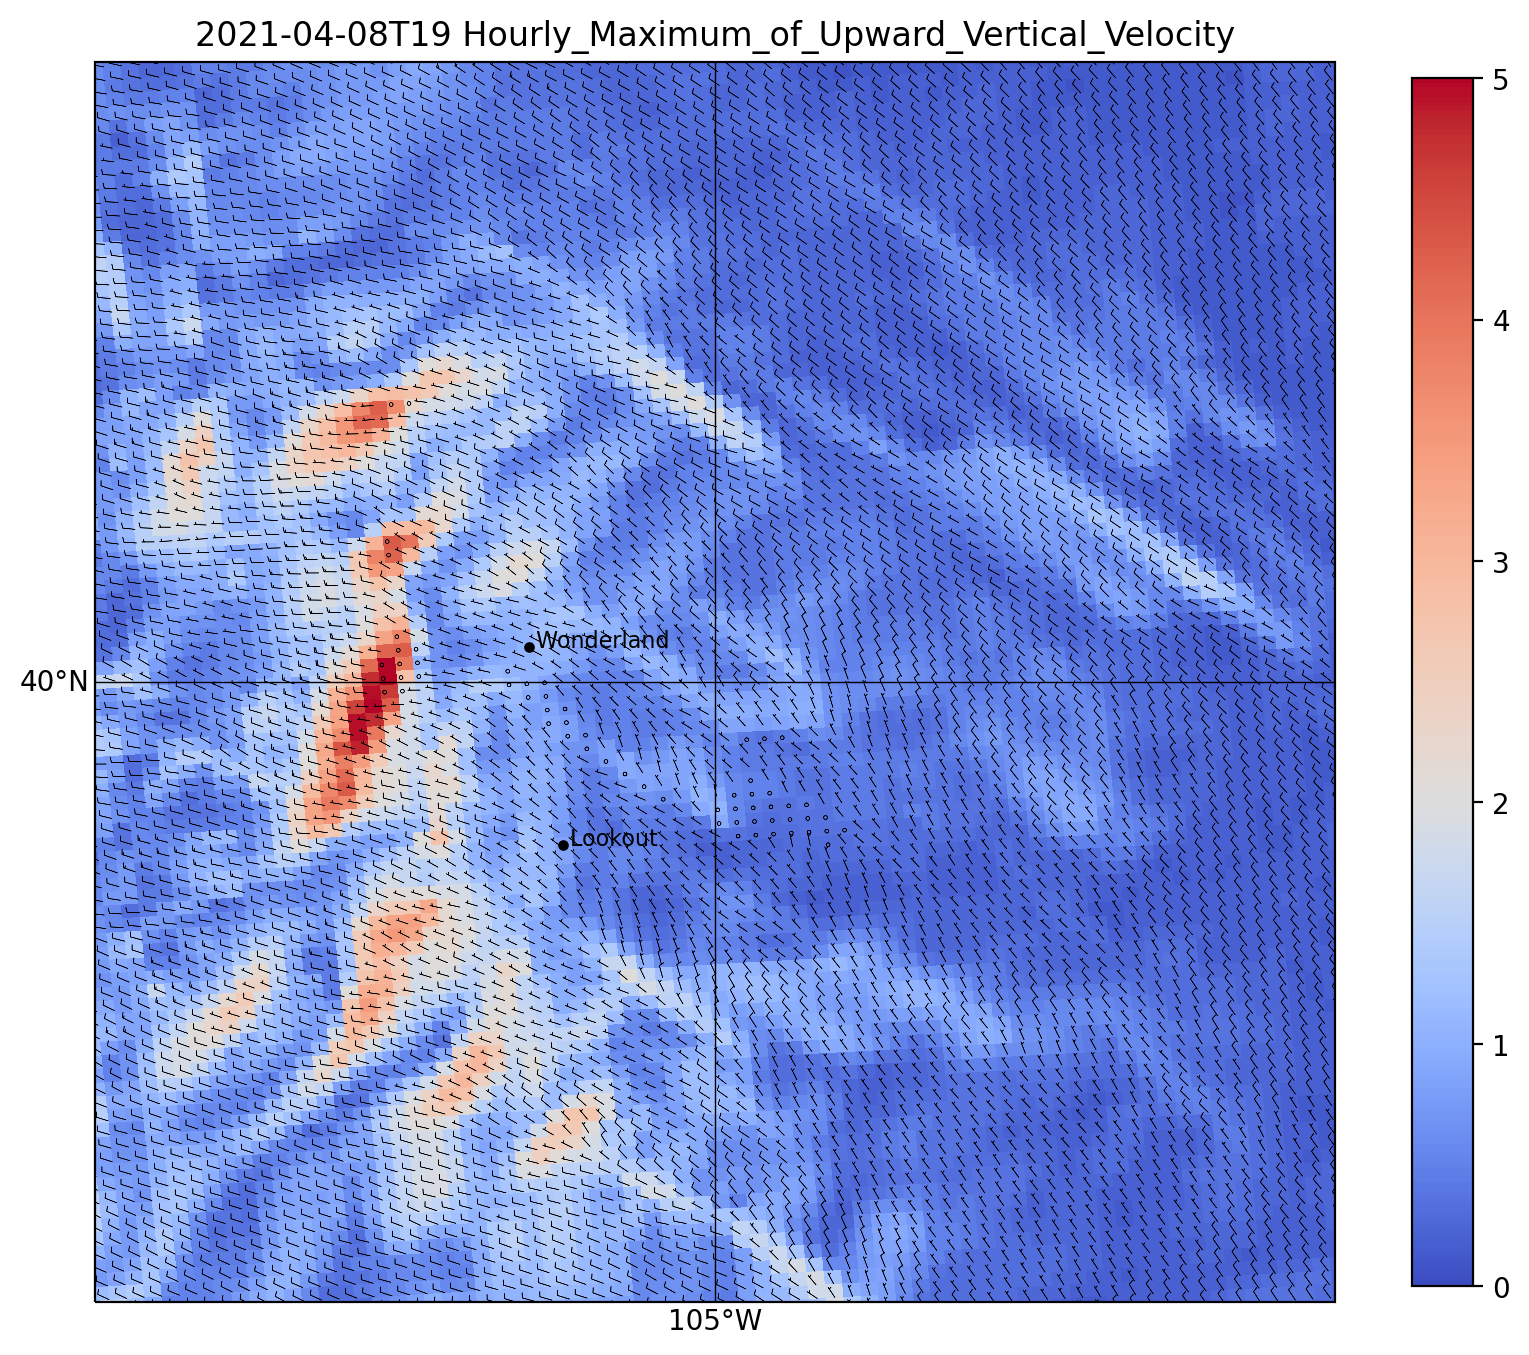

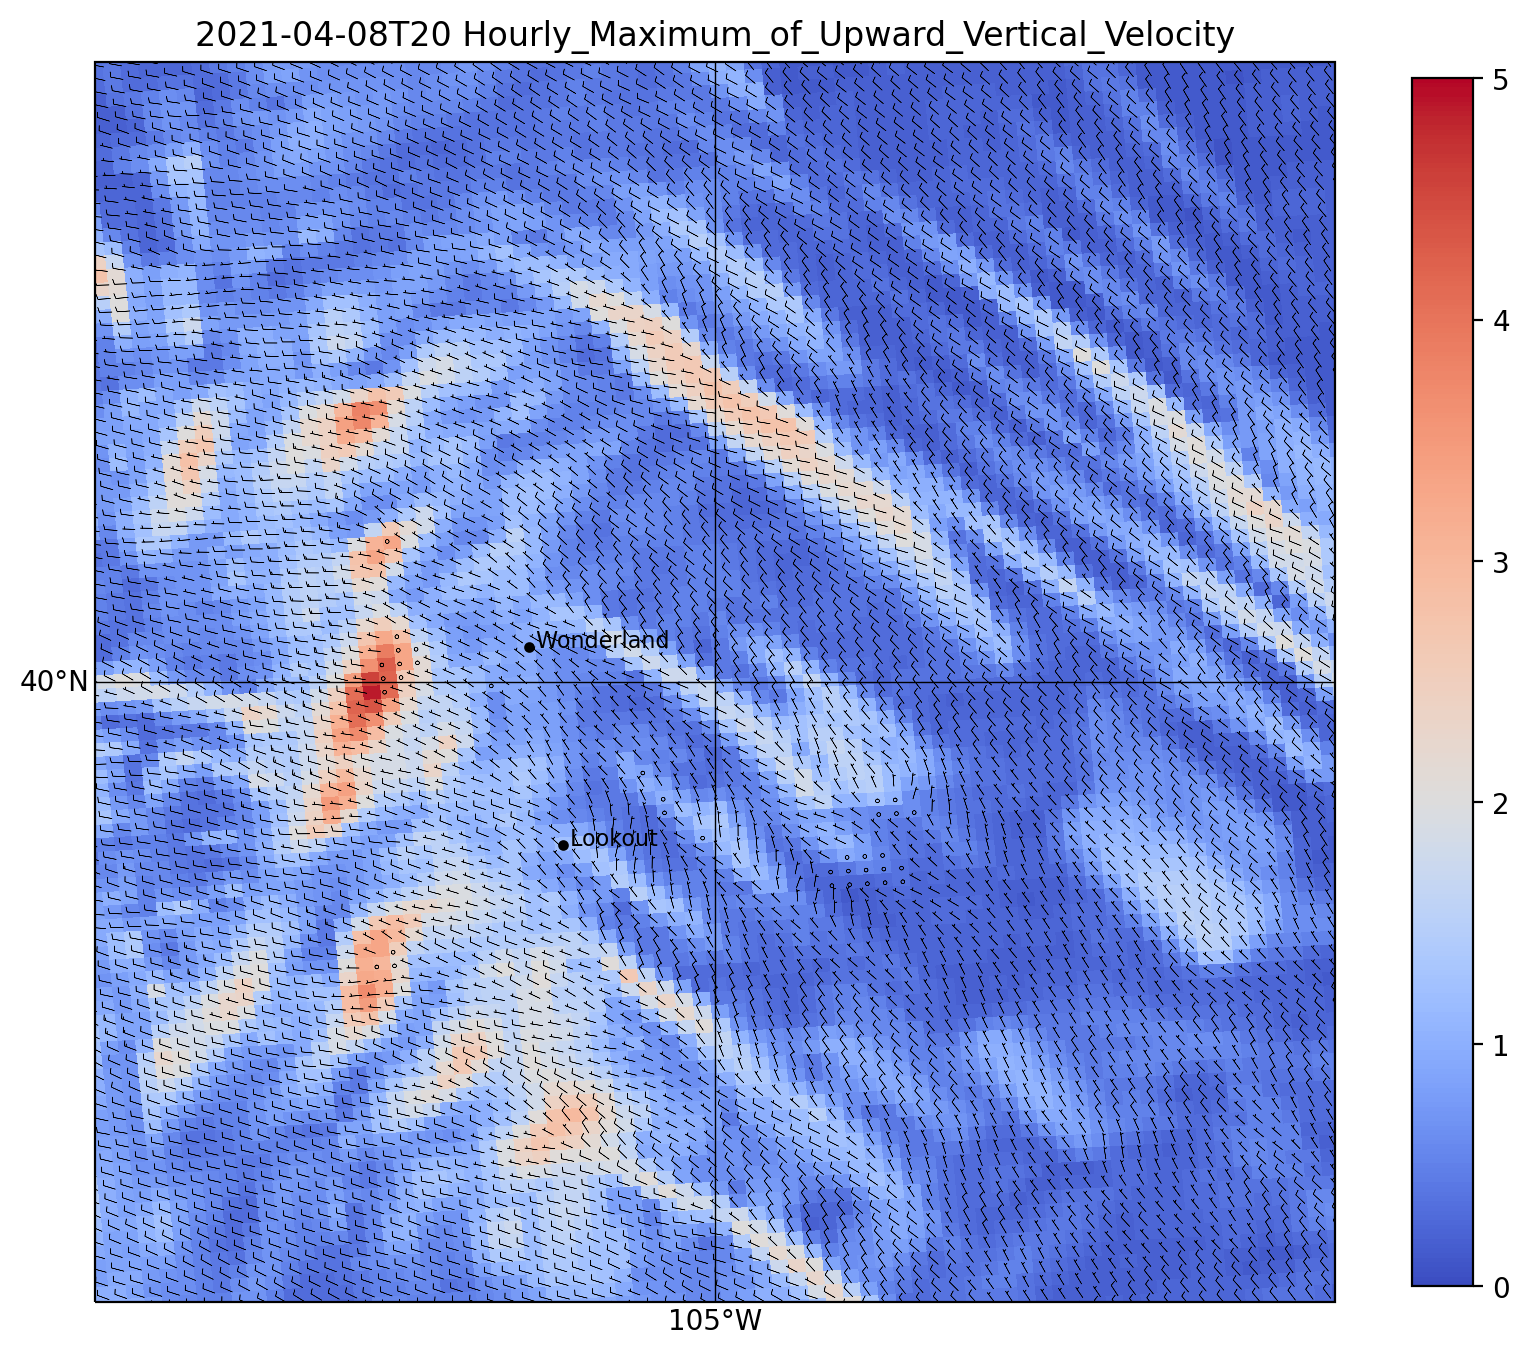

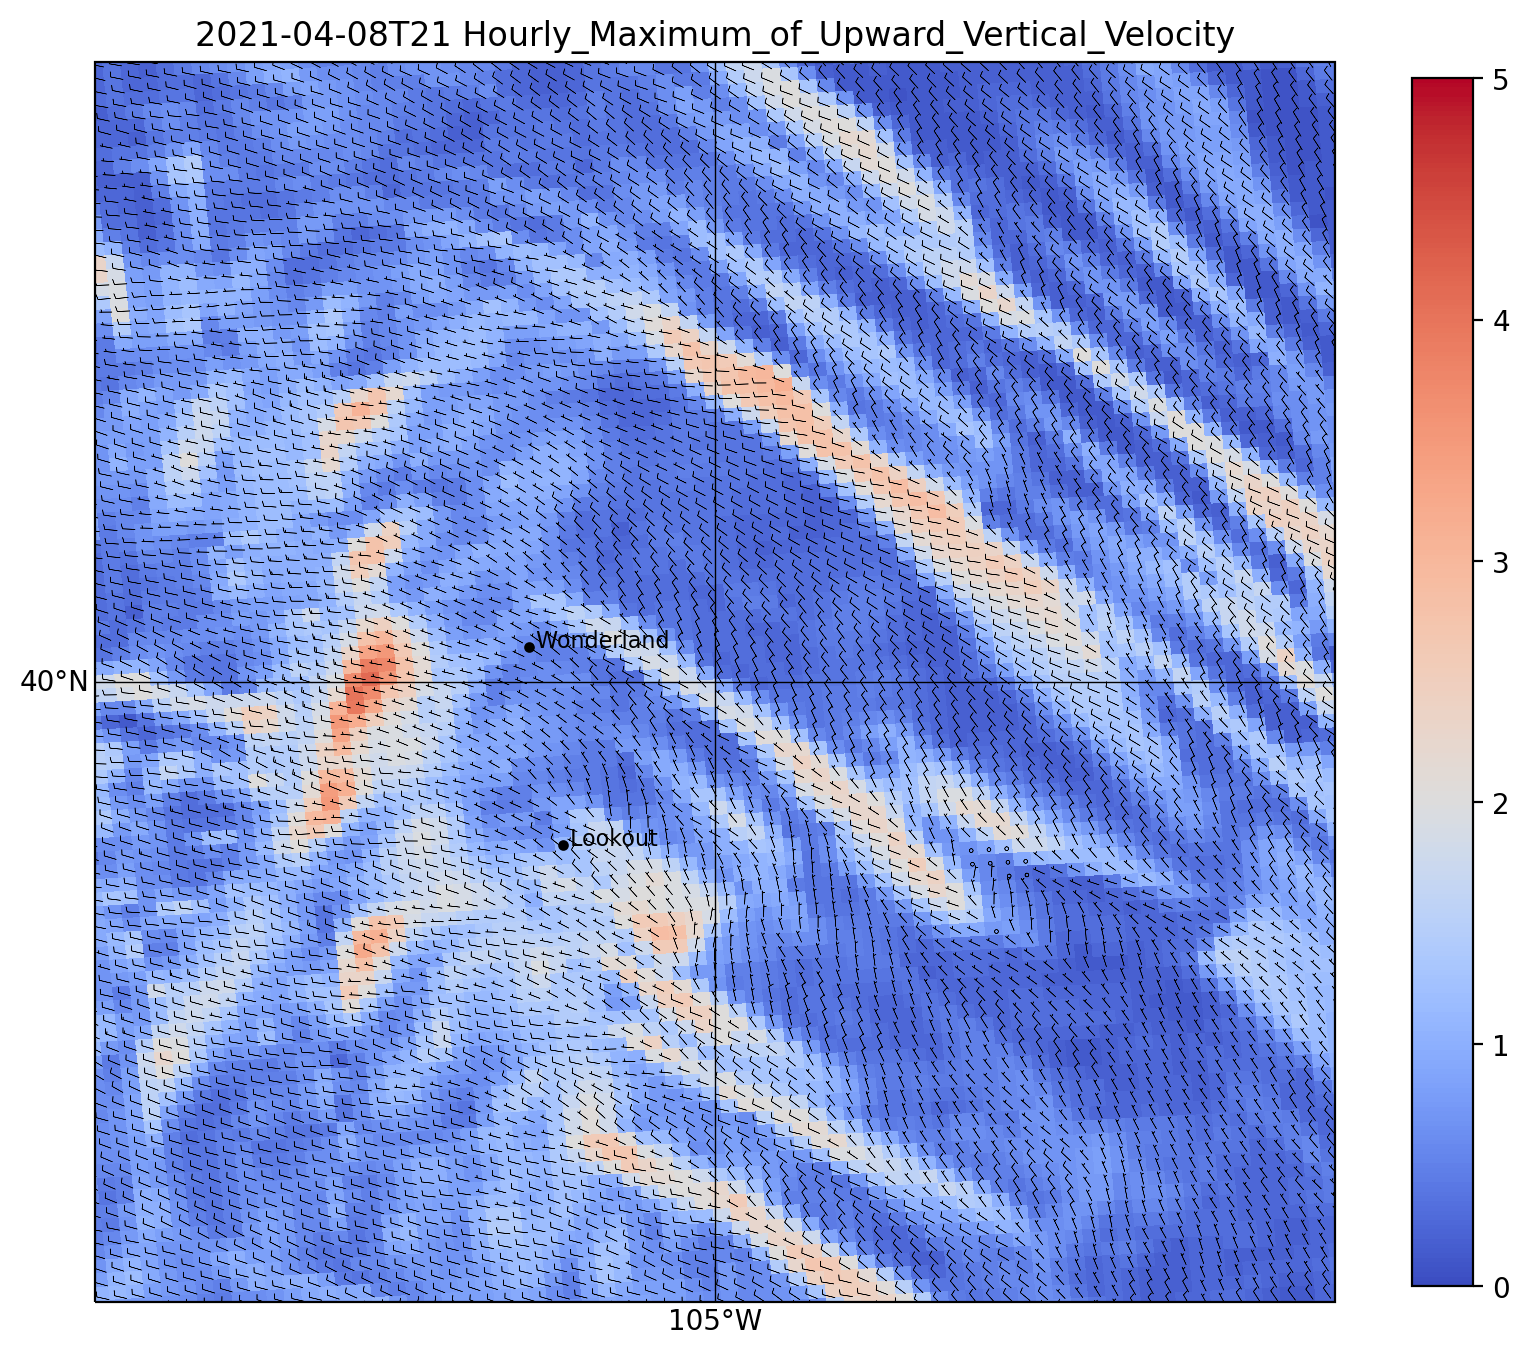

In [16]:
hr.isobar = 1
hr.update()
for x in range(17,22,1):
    hr.forecast(var_name = 'Hourly_Maximum_of_Upward_Vertical_Velocity_in_the_lowest_400hPa_pressure_difference_layer_1_Hour_Maximum', hour = x)